Le but est d'illustrer cette partie : 


Soit $n>1$. Notons $P_k$ le polynôme de 
Legendre de degré $k$. 
Prenons $\Lambda_1$ la mesure uniforme 
sur $[0,1]$. Pour tout $0<\varepsilon<1$,
définissons la mesure de probabilité
$\Lambda_\varepsilon \neq \Lambda_1$
de densité sur $[0,1]$
\[ 
f_\varepsilon(x) = 1 + \varepsilon P_{n-1}(2x-1)
\]

Alors, pour tout $0<\varepsilon<1$, 
\[
\tau_{\Lambda_1} \overset{\mathcal{L}}{=} \tau_{\Lambda_\varepsilon}
\]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
import math

In [2]:
# Helpers: Legendre density, rates, generator, simulation, theoretical density, ECDF
import numpy as np
from numpy.polynomial.legendre import legval
import math

# P_{deg} on [-1,1]
def legendre_P(deg, z):
    coeffs = np.zeros(deg + 1)
    coeffs[-1] = 1.0
    return legval(z, coeffs)

# Density f_ε(x) = 1 + ε P_{n-1}(2x-1) on [0,1]
def f_epsilon(x, eps, n):
    z = 2.0 * x - 1.0
    return 1.0 + eps * legendre_P(n - 1, z)

# Build r_{b,k} and λ_b for uniform Λ on [0,1]
# r_{b,k} = C(b,k) * Beta(k-1, b-k+1) = C(b,k)/[(b-1)*C(b-2, k-2)]
def build_rates_uniform(n):
    r = {b: {} for b in range(2, n + 1)}
    lam = {}
    for b in range(2, n + 1):
        lam_b = 0.0
        for k in range(2, b + 1):
            beta = 1.0 / ((b - 1) * math.comb(b - 2, k - 2))
            r_bk = math.comb(b, k) * beta
            r[b][k] = r_bk
            lam_b += r_bk
        lam[b] = lam_b
    return r, lam

# Generator matrix R (states 2..n)
def build_R_matrix(n, r, lam):
    m = n - 1
    R = np.zeros((m, m), dtype=float)
    for b in range(2, n + 1):
        i = b - 2
        R[i, i] = -lam[b]
        for k in range(2, b + 1):
            new_b = b - k + 1
            if new_b >= 2:
                j = new_b - 2
                R[i, j] += r[b][k]
    return R

# Simulate TMRCA via Markov jump process using rates
def simulate_tau(n, nsims, r, lam, rng):
    taus = np.empty(nsims, dtype=float)
    for s in range(nsims):
        b = n
        t = 0.0
        while b > 1:
            lb = lam[b]
            t += rng.exponential(1.0 / lb)
            ks = np.arange(2, b + 1)
            probs = np.fromiter((r[b][k] for k in ks), dtype=float)
            probs /= probs.sum()
            k = rng.choice(ks, p=probs)
            b = b - k + 1
        taus[s] = t
    return taus

# Theoretical density and CDF via ODE p'(t) = p(t) R
# Returns f(t), F(t), S(t) on t_grid (uniform)
def density_from_R(R, t_grid):
    m = R.shape[0]
    e_n = np.zeros(m)
    e_n[-1] = 1.0
    ones = np.ones(m)
    dt = float(t_grid[1] - t_grid[0])

    p = e_n.copy()
    S = np.empty_like(t_grid)
    f = np.empty_like(t_grid)

    S[0] = p.sum()
    f[0] = -(p @ (R @ ones))

    for i in range(1, len(t_grid)):
        # RK4
        k1 = p @ R
        k2 = (p + 0.5 * dt * k1) @ R
        k3 = (p + 0.5 * dt * k2) @ R
        k4 = (p + dt * k3) @ R
        p = p + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        S[i] = p.sum()
        f[i] = -(p @ (R @ ones))

    F = 1.0 - S
    # Clip for numerical safety
    F = np.clip(F, 0.0, 1.0)
    f = np.clip(f, 0.0, None)
    return f, F, S

# Empirical CDF on grid
def ecdf_on_grid(samples, t_grid):
    s = np.sort(samples)
    idx = np.searchsorted(s, t_grid, side="right")
    return idx / s.size


In [3]:
# Parameters and plotting
np.random.seed(42)
rng = np.random.default_rng(42)

# Model size and epsilons for densities
n = 10
eps = [0.0, 0.5]  # plusieurs ε pour illustrer

# Precompute rates and generator for Λ uniform
r, lam = build_rates_uniform(n)
R = build_R_matrix(n, r, lam)

# Monte Carlo for TMRCA (Uniforme vs "Légendre" — identiques en loi)
nsims = 8000
tau_uniform = simulate_tau(n, nsims, r, lam, rng)
# Pour Λ_ε (mêmes moments jusqu'à n-2) → mêmes taux; tirages indépendants pour variabilité
rng2 = np.random.default_rng(123)
tau_legendre = simulate_tau(n, nsims, r, lam, rng2)

# Time grid for theory and display
q_max = np.quantile(np.concatenate([tau_uniform, tau_legendre]), 0.995)
t_min, t_max = 0.0, float(q_max)
nb_t = 300
t_grid = np.linspace(t_min, t_max, nb_t)

# Theoretical density from generator (Λ uniform)
f_th, F_th, S_th = density_from_R(R, t_grid)


In [4]:
from matplotlib.gridspec import GridSpec

unif 1.7273887206754595
legendre 1.7331179967160184


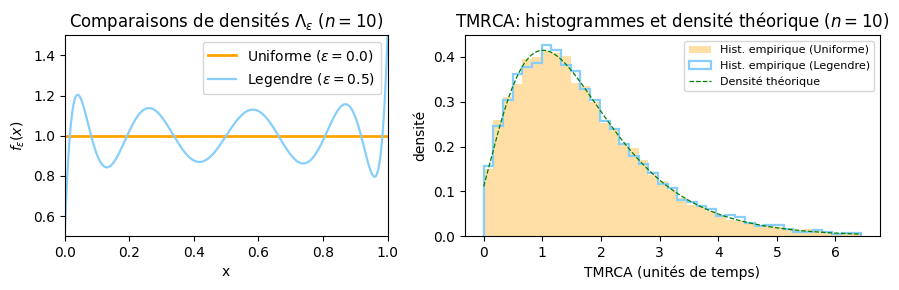

In [5]:
fig = plt.figure(figsize=(9, 3))
gs = GridSpec(1, 2, width_ratios=[1.05, 1.35])
ax_left = fig.add_subplot(gs[0, 0])
ax_top = fig.add_subplot(gs[0, 1])

# --- Left: densities f_ε(x) ---
x = np.linspace(0.0, 1.0, 800)
# $f_\varepsilon(x)=1+\varepsilon P_{n-1}(2x-1)$ 
ax_left.plot(x, f_epsilon(x, eps[0], n), c="orange",       label=fr"Uniforme ($\varepsilon={eps[0]}$)", linewidth=2 if eps[0] == 0.0 else 1.6)
ax_left.plot(x, f_epsilon(x, eps[1], n), c="lightskyblue", label=fr"Legendre ($\varepsilon={eps[1]}$)", linewidth=1.6)

ax_left.set_xlim(0.0, 1.0)
ax_left.set_ylim(0.5, 1.5)
ax_left.set_xlabel("x")
ax_left.set_ylabel("$f_\\varepsilon(x)$")
ax_left.set_title("Comparaisons de densités $\\Lambda_\\varepsilon$ ($n=10$)")
# ax_left.grid(True, linestyle=":", linewidth=0.5)
ax_left.legend()

# --- Right: histograms + theoretical density ---
bins = np.linspace(t_min, t_max, 40)
ax_top.hist(tau_uniform, bins=bins, color="orange", density=True, alpha=0.35, label="Hist. empirique (Uniforme)")
ax_top.hist(tau_legendre, bins=bins, linewidth=1.6, color="lightskyblue", density=True, histtype="step", label="Hist. empirique (Legendre)")
ax_top.plot(t_grid, f_th, "--", linewidth=0.9, c="green", label="Densité théorique")
ax_top.set_xlabel("TMRCA (unités de temps)")
ax_top.set_ylabel("densité")
ax_top.set_title("TMRCA: histogrammes et densité théorique ($n=10$)")
ax_top.legend(fontsize=8)
# ax_top.grid(True, linestyle=":", linewidth=0.5)

fig.tight_layout()
print("unif",tau_uniform.mean())
print("legendre",tau_legendre.mean())


In [6]:
fig.savefig("LaTeX/photo/plot_foret_pas_grande.svg")
fig.savefig("LaTeX/photo/plot_foret_pas_grande.png", dpi=300)
